# Dado magnético - Serra do Cabral

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import griddata, interp1d, interp2d, interpolate

In [2]:
# Carregar o dado
x, y, z = np.loadtxt('cabral.dat', skiprows = 1, usecols = (0,1,4), unpack=True)

In [3]:
from codes.statistical import analysis
print 'Dado magnetico original:'
_ = analysis(z, 'nT')

Dado magnetico original:
Minimum:    -172.9280 nT
Maximum:    317.3630 nT
Mean value: 10.0603 nT
Variation:  490.2910 nT


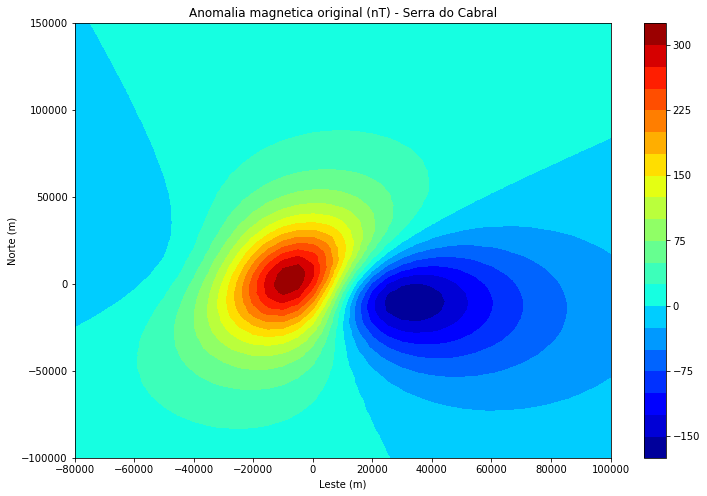

In [4]:
# Mostra o mapa original
plt.close('all')
plt.figure(figsize=(12,8))
plt.tricontourf(x, y, z, 20, cmap = plt.cm.jet)
plt.title('Anomalia magnetica original (nT) - Serra do Cabral')
plt.xlabel('Leste (m)')
plt.ylabel('Norte (m)')
plt.colorbar()

plt.savefig('01-dadomag-original.png')
plt.show()

In [13]:
# Nova area e novo shape para o dado
area = [x.min(), x.max(), y.min(), y.max()]
shape = (50, 50)

In [14]:
# Interpolando o dado
xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
xnew, ynew = np.meshgrid(xi, yi)

In [15]:
# Uso do grid data
znew = griddata((x, y), z, (xnew, ynew))

In [16]:
# Estatistica do dado
print 'Dado magnetico gridado:'
_ = analysis(znew, 'nT')

Dado magnetico gridado:
Minimum:    -170.7816 nT
Maximum:    314.4277 nT
Mean value: 10.1863 nT
Variation:  485.2094 nT


In [17]:
print 'Diferenca de maximo (nT):', np.abs(znew.max() - z.max())
print 'Diferenca de minimo (nT):', np.abs(znew.min() - z.min())
print 'Diferenca de medias (nT):', np.abs(znew.mean() - z.mean())

Diferenca de maximo (nT): 2.93526530612
Diferenca de minimo (nT): 2.14636734694
Diferenca de medias (nT): 0.125978114277


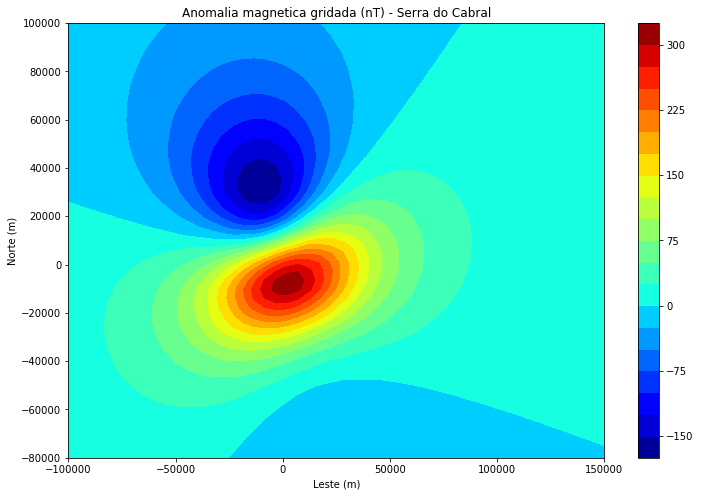

In [29]:
plt.close('all')
plt.figure(figsize=(12,8))
plt.contourf(ynew, xnew, znew, 20, cmap = plt.cm.jet)
plt.title('Anomalia magnetica gridada (nT) - Serra do Cabral')
plt.xlabel('Leste (m)')
plt.ylabel('Norte (m)')
plt.colorbar()

plt.savefig('02-dadomag-gridado.png')
plt.show()

## Teste para redução ao Polo

In [41]:
# Valores informados no trabalho (Cosme)
inc, dec = -17., -17.5
incs, decs = 59., -48.
polo = (90., 0.)

In [42]:
from codes.filtering import reduction
from fatiando.gravmag.transform import reduce_to_pole

In [43]:
# Reducao ao Polo calculada atraves das funcoes 
rtp_n = reduction(ynew, xnew, znew, (inc, dec), (incs, decs), polo, polo)

In [44]:
x_fa, y_fa, z_fa = xnew.reshape(xnew.size), ynew.reshape(ynew.size), znew.reshape(xnew.size)

In [45]:
# Reducao ao Polo calculada via Fatiando
rtp_f = reduce_to_pole(y_fa, x_fa, z_fa, (50, 50), inc, dec, incs, decs)

In [46]:
print 'Reducao via funcoes:'
_ = analysis(rtp_n, 'nT')

Reducao via funcoes:
Minimum:    -341.6697 nT
Maximum:    422.5669 nT
Mean value: 0.0000 nT
Variation:  764.2366 nT


In [47]:
print 'Reducao via fatiando:'
_ = analysis(rtp_f, 'nT')

Reducao via fatiando:
Minimum:    -568.7213 nT
Maximum:    318.3385 nT
Mean value: -0.0000 nT
Variation:  887.0598 nT


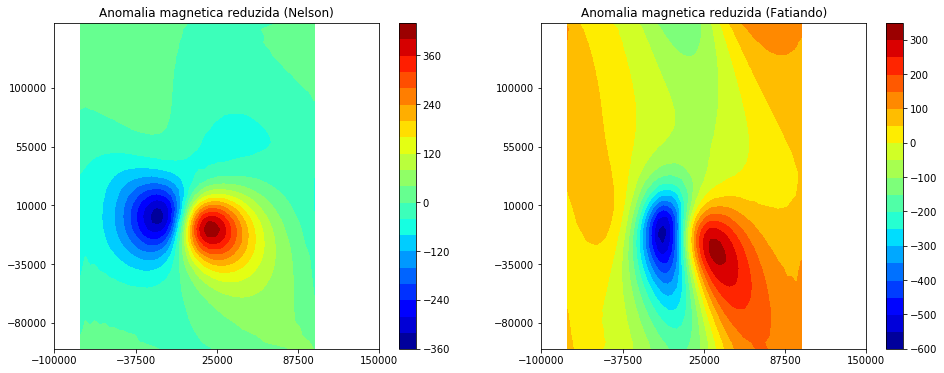

In [73]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.contourf(xnew, ynew, rtp_n, 20, cmap = plt.cm.jet)
plt.title('Anomalia magnetica reduzida (Nelson)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.contourf(xnew, ynew, rtp_f.reshape(shape), 20, cmap = plt.cm.jet)
plt.title('Anomalia magnetica reduzida (Fatiando)')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('03-reducao-polo.png')

plt.show()

## Teste para a Correlacao Cruzada

In [50]:
from codes.statistical import cccoef

### (1) TGA e VG do dado reduzido ao Polo

In [51]:
from codes.derivative import totalgrad, zderiv

In [55]:
tga_data = totalgrad(yi, xi, znew)
vga_data = zderiv(yi, xi, znew, 1.)

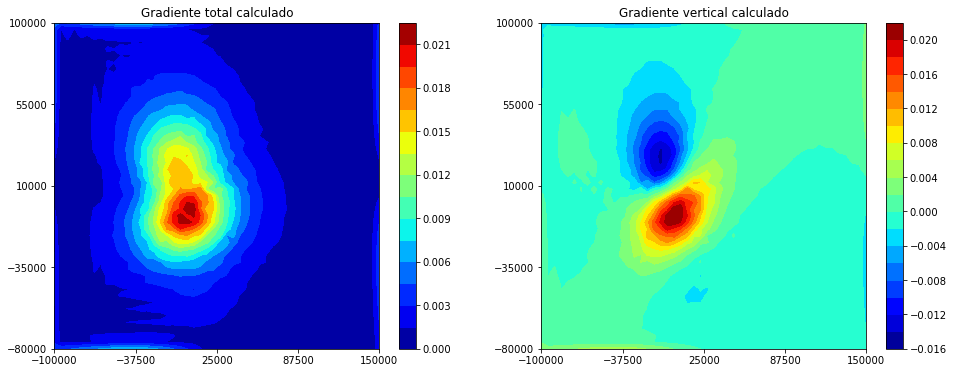

In [74]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.contourf(ynew, xnew, tga_data, 20, cmap = plt.cm.jet)
plt.title('Gradiente total calculado')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.contourf(ynew, xnew, vga_data, 20, cmap = plt.cm.jet)
plt.title('Gradiente vertical calculado')
plt.yticks(np.linspace(x.min(), x.max(), 5))
plt.xticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('04-tga_vga.png')

plt.show()

In [75]:
ip = np.arange(-90., 91.)
im = np.arange(-90., -14.)
d = np.arange(-150., 151.)
D, Ip = np.meshgrid(d, ip)
_, Im = np.meshgrid(d, im)

In [76]:
# Cria a matriz de coeficientes
cc_plus = np.zeros((ip.size, d.size))
cc_minus = np.zeros((im.size, d.size))

In [ ]:
# Calculando a correlacao para inclinacao positiva
for ki in range(ip.size):
    for kd in range(d.size):
        rtp = reduction(ynew, xnew, znew, (inc, dec), (ip[ki], d[kd]), polo, polo)
        tga = totalgrad(xi, yi, rtp)
        vga = zderiv(xi, yi, rtp, 1)
        cc_plus[ki, kd] = cccoef(tga, vga)

In [ ]:
# Calculando a correlacao para inclinacao positiva
for ki in range(im.size):
    for kd in range(d.size):
        rtp = reduction(ynew, xnew, znew, (inc, dec), (im[ki], d[kd]), polo, polo)
        tga = totalgrad(xi, yi, rtp)
        vga = zderiv(xi, yi, rtp, 1)
        cc_minus[ki, kd] = cccoef(tga, vga)

In [61]:
# Analisando os valores de maximo e minimo
print 'Intervalo para inclinacao positiva:'
_ = analysis(cc_plus)
print 
print 'Intervalo para inclinacao negativa:'
_ = analysis(cc_minus)

Intervalo para inclinacao positiva:
Minimum:    -0.0747
Maximum:    0.5215
Mean value: 0.2328
Variation:  0.5962

Intervalo para inclinacao negativa:
Minimum:    -0.6882
Maximum:    -0.0070
Mean value: -0.2862
Variation:  0.6813


In [62]:
def find_index(data):
    '''
    This function returns the index where maximum and minimum are located.
    Inputs:
    data - numpy array - values in a grid
    
    Output:
    ind_max - tuple - pair of grid index for maximum values
    ind_min - tuple - pair of grid index for minimum values
    '''
    
    if data.ndim == 1.:
        imax = np.where(data == data.max())
        imin = np.where(data == data.min())
        res_max = imax
        res_min = imin
    else:
        imax, jmax = np.where(data == data.max())
        imin, jmin = np.where(data == data.min())
        res_max = (imax, jmax)
        res_min = (imin, jmin)
    
    # Return the final output
    return res_max, res_min

In [63]:
# Find the index
maxi1, mini1 = find_index(cc_plus)
imax1, jmax1 = maxi1
imin1, jmin1 = mini1

In [64]:
# Find the index
maxi2, mini2 = find_index(cc_minus)
imax2, jmax2 = maxi2
imin2, jmin2 = mini2

In [65]:
print 'Indices maximos:', maxi1
print 'Indices minimos:', mini1
print 'Incl e Dec calculados (maximo):', Im[imax1, jmax1], D[imax1, jmax1]
print 'Incl e Dec calculados (minimo):', Im[imin1, jmin1], D[imin1, jmin1]

Indices maximos: (array([0]), array([300]))
Indices minimos: (array([0]), array([138]))
Incl e Dec calculados (maximo): [-90.] [ 150.]
Incl e Dec calculados (minimo): [-90.] [-12.]


In [66]:
print 'Indices maximos:', maxi2
print 'Indices minimos:', mini2
print 'Incl e Dec calculados (maximo):', Im[imax2, jmax2], D[imax2, jmax2]
print 'Incl e Dec calculados (minimo):', Im[imin2, jmin2], D[imin2, jmin2]

Indices maximos: (array([75]), array([253]))
Indices minimos: (array([75]), array([140]))
Incl e Dec calculados (maximo): [-15.] [ 103.]
Incl e Dec calculados (minimo): [-15.] [-10.]


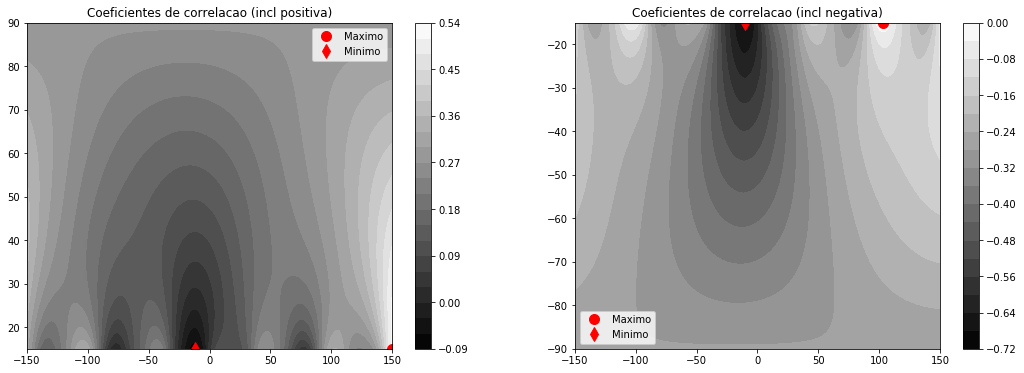

In [67]:
# Plotando os coeficientes calculados
plt.close('all')
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.contourf(D, Ip, cc_plus, 20, cmap = plt.cm.gray)
plt.plot(D[imax1, jmax1], Ip[imax1, jmax1], 'ro', markersize = 10, label = 'Maximo')
plt.plot(D[imin1, jmin1], Ip[imin1, jmin1], 'rd', markersize = 10, label = 'Minimo')
plt.title('Coeficientes de correlacao (incl positiva)')
plt.legend(loc = 'upper right')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.contourf(D, Im, cc_minus, 20, cmap = plt.cm.gray)
plt.plot(D[imax2, jmax2], Im[imax2, jmax2], 'ro', markersize = 10, label = 'Maximo')
plt.plot(D[imin2, jmin2], Im[imin2, jmin2], 'rd', markersize = 10, label = 'Minimo')
plt.title('Coeficientes de correlacao (incl negativa)')
plt.legend(loc = 'lower left')
plt.colorbar()

plt.savefig('06-correlacao.png')
plt.show()

In [68]:
# Calcula a reducao ao Polo para os valores de maximo e minimo encontrados
rtp_max_plus = reduction(xi, yi, znew, (inc, dec), (D[imax1, jmax1], Ip[imax1, jmax1]), polo, polo)
rtp_min_plus = reduction(xi, yi, znew, (inc, dec), (D[imin1, jmin1], Ip[imin1, jmin1]), polo, polo)

In [69]:
# Calcula a reducao ao Polo para os valores de maximo e minimo encontrados
rtp_max_minus = reduction(xi, yi, znew, (inc, dec), (D[imax2, jmax2], Im[imax2, jmax2]), polo, polo)
rtp_min_minus = reduction(xi, yi, znew, (inc, dec), (D[imin2, jmin2], Im[imin2, jmin2]), polo, polo)

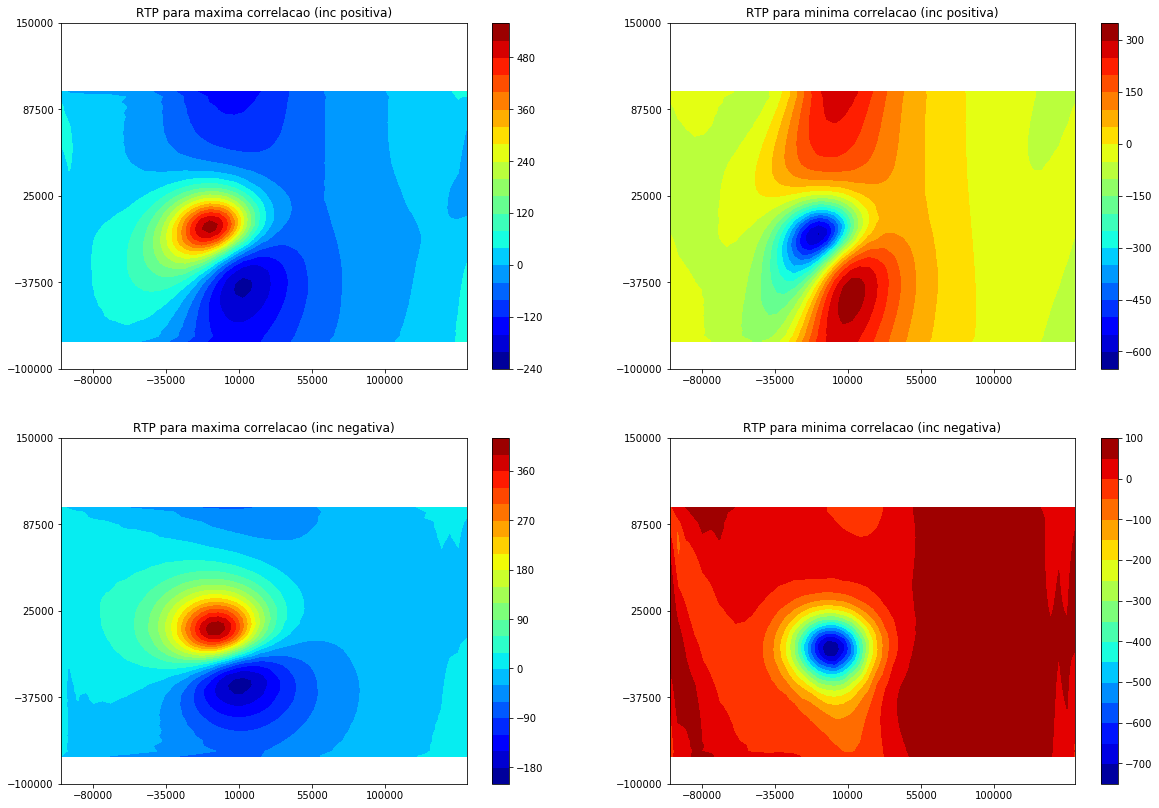

In [71]:
# Imprime os valores de reducao calculados
plt.close('all')
plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
plt.contourf(ynew, xnew, rtp_max_plus, 20, cmap = plt.cm.jet)
plt.title('RTP para maxima correlacao (inc positiva)')
plt.xticks(np.linspace(x.min(), x.max(), 5))
plt.yticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.contourf(ynew, xnew, rtp_min_plus, 20, cmap = plt.cm.jet)
plt.title('RTP para minima correlacao (inc positiva)')
plt.xticks(np.linspace(x.min(), x.max(), 5))
plt.yticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()
          
plt.subplot(2, 2, 3)
plt.contourf(ynew, xnew, rtp_max_minus, 20, cmap = plt.cm.jet)
plt.title('RTP para maxima correlacao (inc negativa)')
plt.xticks(np.linspace(x.min(), x.max(), 5))
plt.yticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.contourf(ynew, xnew, rtp_min_minus, 20, cmap = plt.cm.jet)
plt.title('RTP para minima correlacao (inc negativa)')
plt.xticks(np.linspace(x.min(), x.max(), 5))
plt.yticks(np.linspace(y.min(), y.max(), 5))
plt.colorbar()

plt.savefig('07-rtp_calculada.png')

plt.show()

### (2) TGA do dado reduzido ao Polo e HGA do dado pseudogravimetrico